# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

Установим нужные нам модули, импортируем библлиотеки и выгрузим данные

In [1]:
!pip install catboost


In [2]:
!pip install lightgbm

In [3]:
pip install category_encoders

Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import catboost as cb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from catboost import CatBoostRegressor, cv, train
from sklearn.preprocessing import RobustScaler, StandardScaler
import category_encoders as ce
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import time
from sklearn.model_selection import cross_val_score, GridSearchCV , train_test_split 
from sklearn.metrics import make_scorer, mean_squared_error 
# import warnings
# warnings.filterwarnings('ignore')


In [5]:
try:
    df = pd.read_csv('/datasets/autos.csv')
    df.info()
except:
    print('alarm, волк унес зайчат')

    
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


В данных много пропусков, изучим этот момент и приведем данные к рабочему виду

In [6]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [7]:
df['Repaired'].value_counts(normalize=True)

no     0.872697
yes    0.127303
Name: Repaired, dtype: float64

In [8]:
df['Model'].unique()

array(['golf', nan, 'grand', 'fabia', '3er', '2_reihe', 'other', 'c_max',
       '3_reihe', 'passat', 'navara', 'ka', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'meriva', 'arosa', 'c4', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'kangoo', 'corsa', 'one',
       'fortwo', '1er', 'b_klasse', 'signum', 'astra', 'a8', 'jetta',
       'fiesta', 'c_klasse', 'micra', 'vito', 'sprinter', '156', 'escort',
       'forester', 'xc_reihe', 'scenic', 'a4', 'a1', 'insignia', 'combo',
       'focus', 'tt', 'a6', 'jazz', 'omega', 'slk', '7er', '80', '147',
       '100', 'z_reihe', 'sportage', 'sorento', 'v40', 'ibiza', 'mustang',
       'eos', 'touran', 'getz', 'a3', 'almera', 'megane', 'lupo', 'r19',
       'zafira', 'caddy', 'mondeo', 'cordoba', 'colt', 'impreza',
       'vectra', 'berlingo', 'tiguan', 'i_reihe', 'espace', 'sharan',
       '6_reihe', 'panda', 'up', 'seicento', 'ceed', '5_reihe', 'yeti',
       'octavia', 'mii', 'rx_reihe', '6er', 'modus', 'fox'

In [9]:
df['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [10]:
df['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [11]:
df['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [12]:
df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [13]:
df['Power'].unique()

array([    0,   190,   163,    75,    69,   102,   109,    50,   125,
         101,   105,   140,   115,   131,    60,   136,   160,   231,
          90,   118,   193,    99,   113,   218,   122,   129,    70,
         306,    95,    61,   177,    80,   170,    55,   143,    64,
         286,   232,   150,   156,    82,   155,    54,   185,    87,
         180,    86,    84,   224,   235,   200,   178,   265,    77,
         110,   144,   120,   116,   184,   126,   204,    88,   194,
         305,   197,   179,   250,    45,   313,    41,   165,    98,
         130,   114,   211,    56,   201,   213,    58,   107,    83,
         174,   100,   220,    85,    73,   192,    68,    66,   299,
          74,    52,   147,    65,   310,    71,    97,   239,   203,
           5,   300,   103,   258,   320,    63,    81,   148,    44,
         145,   230,   280,   260,   104,   188,   333,   186,   117,
         141,    59,   132,   234,   158,    39,    92,    51,   135,
          53,   209,

Убираем ненужные столбцы

In [14]:
df.drop(['DateCrawled',
         'RegistrationMonth', 'DateCreated', 'NumberOfPictures',
         'PostalCode', 'LastSeen'],
        axis='columns', inplace=True)

заполняем пропуски в данных

In [15]:
df['Repaired'] = df['Repaired'].fillna("no") #был ли ремонт

In [16]:
df['Model'] = df['Model'].fillna('other') #модель машины

In [17]:
df['Gearbox'] = df['Gearbox'].fillna("other") #какая коробка

In [18]:
df['VehicleType'] = df['VehicleType'].fillna("other") #кузов

In [19]:
df['FuelType'] = df['FuelType'].fillna("other") #тип топлива

Убираем аномальные значения : год постановления на учет и количество лошадиных сил

In [20]:
df = df.query('1980 <= RegistrationYear <= 2016')

In [21]:
df = df.query('50 <= Power <= 1500')

Проверяем и удаляем дубликаты

In [22]:
df.duplicated().sum()

45551

In [23]:
df = df.drop_duplicates()
print(df.duplicated().sum())

0


Посмотрим на данные

In [24]:
numeric = []
for i in df.columns:
    if df[i].dtypes == 'int64':
        numeric.append(i)

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


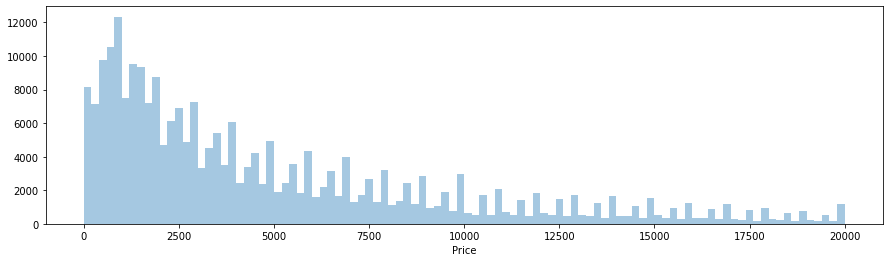

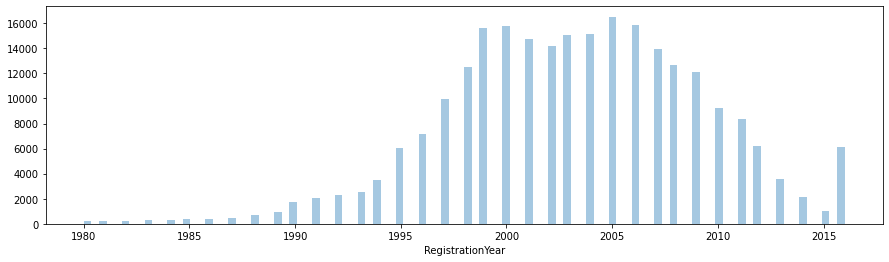

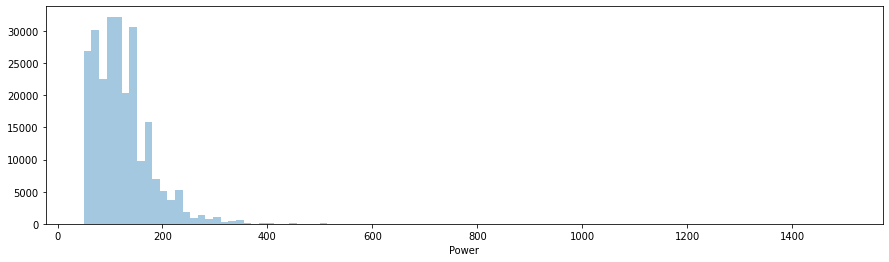

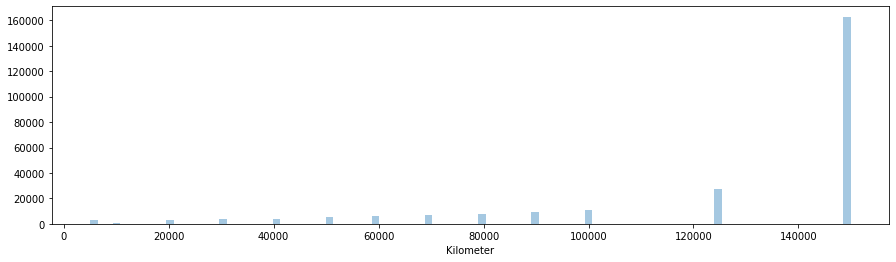

In [25]:
for i in numeric:
    plt.figure(figsize=(15, 4))
    sns.distplot(df[i], kde=False, bins=100)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250093 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             250093 non-null  int64 
 1   VehicleType       250093 non-null  object
 2   RegistrationYear  250093 non-null  int64 
 3   Gearbox           250093 non-null  object
 4   Power             250093 non-null  int64 
 5   Model             250093 non-null  object
 6   Kilometer         250093 non-null  int64 
 7   FuelType          250093 non-null  object
 8   Brand             250093 non-null  object
 9   Repaired          250093 non-null  object
dtypes: int64(4), object(6)
memory usage: 21.0+ MB


In [27]:
df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
354361,5250,other,2016,auto,150,159,150000,other,alfa_romeo,no
354362,3200,sedan,2004,manual,225,leon,150000,petrol,seat,yes
354366,1199,convertible,2000,auto,101,fortwo,125000,petrol,smart,no
354367,9200,bus,1996,manual,102,transporter,150000,gasoline,volkswagen,no


Выводы по предобработке:
1.Удалили ненужные строки

2.Заменили пропуски в столбце `Repaired` на "no" , думаю что если не указали, знаичт не ремонтировались(допустим мы живем в идеальном мире без врунов)

3.В столбцах "модель, коробка, тип кузова и топливо" были значения `other` на них и заменили пропуски

4.Отфильтровали данные в столбце год  регистрации от 1980 до 2022 и в столбце лошадиные силы от 50 до 1500( допустим на нашей площадке будут продавать такие машины как Koenigsegg)

Данные отшлифованны , будет приступать к обучению модели

## Обучение моделей

Разобьем данные на 3 выборки
Закодируем данные для дальнейшего обучения

In [28]:
df_encoded = df.drop(['Model', 'Brand'], axis=1)

In [29]:
ohe = OneHotEncoder()
df_encoded = pd.get_dummies(df_encoded)

In [30]:
df_encoded = pd.concat([df[['Model', 'Brand']], df_encoded], axis=1)

In [31]:
df_encoded

,Model,Brand,Price,RegistrationYear,Power,Kilometer,VehicleType_bus,VehicleType_convertible,VehicleType_coupe,VehicleType_other,...,Gearbox_other,FuelType_cng,FuelType_electric,FuelType_gasoline,FuelType_hybrid,FuelType_lpg,FuelType_other,FuelType_petrol,Repaired_no,Repaired_yes
1,other,audi,18300,2011,190,125000,0,0,1,0,...,0,0,0,1,0,0,0,0,0,1
2,grand,jeep,9800,2004,163,125000,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,golf,volkswagen,1500,2001,75,150000,0,0,0,0,...,0,0,0,0,0,0,0,1,1,0
4,fabia,skoda,3600,2008,69,90000,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
5,3er,bmw,650,1995,102,150000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354361,159,alfa_romeo,5250,2016,150,150000,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
354362,leon,seat,3200,2004,225,150000,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
354366,fortwo,smart,1199,2000,101,125000,0,1,0,0,...,0,0,0,0,0,0,0,1,1,0
354367,transporter,volkswagen,9200,1996,102,150000,1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


In [32]:
# target = df_encoded.drop('Price', axis=1)
# features = df_encoded['Price']

In [33]:
df_train, df_valid, df_test = np.split(df_encoded.sample(frac=1, random_state=12345), [int(.6*len(df)), int(.8*len(df))])

In [34]:
features_train = df_train.drop(['Price'], axis=1)
target_train = df_train['Price']
features_valid = df_valid.drop(['Price'], axis=1)
target_valid = df_valid['Price']
test_features = df_test.drop(['Price'], axis=1)
test_target = df_test['Price']

In [ ]:
print("Train shape:", df_train.shape)
print("Valid shape:", df_valid.shape)
print("Test shape:", df_test.shape)

Закодируем все данные!!!
Для начала таргет энкод

In [36]:
target_encoder = ce.TargetEncoder()
encoded_features_train = target_encoder.fit_transform(features_train[['Brand', 'Model']], target_train)

encoded_features_valid = target_encoder.transform(features_valid[['Brand', 'Model']])

encoded_test_features = target_encoder.transform(test_features[['Brand', 'Model']])

Далее OHE

In [37]:
onehot_encoder = OneHotEncoder()
encoded_features_train = pd.get_dummies(features_train.drop(['Brand', 'Model'], axis=1))
encoded_features_valid = pd.get_dummies(features_valid.drop(['Brand', 'Model'], axis=1))
encoded_test_features = pd.get_dummies(test_features.drop(['Brand', 'Model'], axis=1))

Затем масштабируем данные

In [38]:
scaler = StandardScaler()
scaled_features_train = scaler.fit_transform(encoded_features_train)
scaled_features_valid = scaler.transform(encoded_features_valid)
scaled_test_features = scaler.transform(encoded_test_features)

Напишем функцию для расчета RMSE

In [39]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict)) ** 0.5

RMSE_score = make_scorer(RMSE, greater_is_better=False)

Обучим 4 модели

1.LinearRegression

In [40]:
%%time
linear_reg = LinearRegression()
linear_reg.fit(scaled_features_train, target_train)

linear_reg_rmse_train = RMSE(target_train, linear_reg.predict(scaled_features_train))

print("Linear Regression:")
print("RMSE (Train):", linear_reg_rmse_train)
print('_____________________')

Linear Regression:
RMSE (Train): 4004.3296882945883
_____________________
CPU times: user 7.3 ms, sys: 19.2 ms, total: 26.5 ms
Wall time: 14.3 ms


2.RandomForestRegressor

In [41]:
%%time
rf = RandomForestRegressor(random_state=12345)

rf_param_grid = {
    'n_estimators': [5, 15, 5], 
    'max_depth': [5, 10, 15],  
    'min_samples_split': [2, 5, 10],  
}

rf_grid = GridSearchCV(rf, rf_param_grid, scoring=RMSE_score, cv=5)
rf_grid.fit(scaled_features_train, target_train)

rf_best_params = rf_grid.best_params_
rf_best_model = rf_grid.best_estimator_
rf_rmse_train = RMSE(target_train, rf_best_model.predict(scaled_features_train))

print("Random Forest:")
print("Best Parameters:", rf_best_params)
print("RMSE (Train):", rf_rmse_train)
print('_____________________')

Random Forest:
Best Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 15}
RMSE (Train): 3970.0195218046115
_____________________
CPU times: user 37.3 s, sys: 80.4 ms, total: 37.4 s
Wall time: 38.3 s


3.LGBMRegressor

In [ ]:
%%time
lgbm = lgb.LGBMRegressor(random_state=12345)

lgbm_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001], 
    'n_estimators': [5, 15, 5],  
    'max_depth': [5, 10, 15], 
}

lgbm_grid = GridSearchCV(lgbm, lgbm_param_grid, scoring=RMSE_score, cv=5)
lgbm_grid.fit(scaled_features_train, target_train)

lgbm_best_params = lgbm_grid.best_params_
lgbm_best_model = lgbm_grid.best_estimator_
lgbm_rmse_train = RMSE(target_train, lgbm_best_model.predict(scaled_features_train))

print("LightGBM:")
print("Best Parameters:", lgbm_best_params)
print("RMSE (Train):", lgbm_rmse_train)
print('_____________________')

4.CatBoostRegressor

In [ ]:
%%time
catboost = CatBoostRegressor(random_state=12345, verbose=False)

catboost_param_grid = {
    'learning_rate': [0.1, 0.01, 0.001], 
    'n_estimators': [5, 15, 5],  
    'max_depth': [5, 10, 15],  
}

catboost_grid = GridSearchCV(catboost, catboost_param_grid, scoring=RMSE_score, cv=5)
catboost_grid.fit(scaled_features_train, target_train)

catboost_best_params = catboost_grid.best_params_
catboost_best_model = catboost_grid.best_estimator_
catboost_rmse_train = RMSE(target_train, catboost_best_model.predict(scaled_features_train))

print("CatBoost:")
print("Best Parameters:", catboost_best_params)
print("RMSE (Train):", catboost_rmse_train)
print('_____________________')

## Анализ моделей

Проверим результаты моделей на тестовой выборке

1.Линейная регрессия

In [ ]:
%%time
linear_reg_test_rmse = RMSE(test_target, linear_reg.predict(scaled_test_features))
print("Linear Regression (Test RMSE):", linear_reg_test_rmse)
print('_____________________')

2.Случайный лес

In [ ]:
%%time
rf_test_rmse = RMSE(test_target, rf_best_model.predict(scaled_test_features))
print("Random Forest (Test RMSE):", rf_test_rmse)
print('_____________________')

3.LGBMRegressor

In [ ]:
%%time
lgbm_test_rmse = RMSE(test_target, lgbm_best_model.predict(scaled_test_features))
print("LightGBM (Test RMSE):", lgbm_test_rmse)
print('_____________________')

4.CatBoostRegressor

In [ ]:
%%time
catboost_test_rmse = RMSE(test_target, catboost_best_model.predict(scaled_test_features))
print("CatBoost (Test RMSE):", catboost_test_rmse)
print('_____________________')

Соберем все в табличку для наглядности

In [ ]:
columns = ['Модель', 'Время работы модели на тестовой выборке, ms.', 'RMSE',]
regression_model = ['Линейная регрессия', 2.99, linear_reg_test_rmse]
forest_model = ['Случайный лес', 107, rf_test_rmse]
lg_model = ['LGBMRegressor', 15, lgbm_test_rmse]
cb_model = ['CatBoostRegressor', 9.99, catboost_test_rmse]

table = pd.DataFrame([regression_model, forest_model, lg_model, cb_model], columns = columns)

table

Наилучший показатель RMSE показала модель `Случайный лес` = 1923.74 и временем 107ms. Все модели прошли по порогу RMSE , кроме линейной регрессии. Лучшее время из прошедших порог показала модель CatBoostRegressor -- 9,99ms
ДУмаю лучшая моделью является модель случайного леса и рекомедую ее к работе

Добавим функцию для расчета RMSE

Линейная регрессия

ОБучаем модель и определяем rmse с помощью кросс валидации

In [ ]:
%%time

linear_regression_model = LinearRegression()
linear_regression_model.fit(scaled_features_train, target_train)

predictions_valid = linear_regression_model.predict(scaled_features_valid)

Далее случайный лес

In [ ]:
%%time
forest = RandomForestRegressor()
forest_parametrs = { 'n_estimators': range(5, 15, 5),
                     'max_depth': range(1, 6, 2),
                     'min_samples_leaf': range(1,4),
                     'min_samples_split': range(2,6,2) }

forest_grid = GridSearchCV(forest, forest_parametrs, scoring=RMSE_score, cv=3)
forest_grid.fit(features_test, target_test)

Найдем лучшие параметры

In [ ]:
%%time

forest_params = forest_grid.best_params_
forest_score = forest_grid.score(features_test, target_test) * (-1)
print(forest_params)
print(forest_score)

Далее LGBM регрессия

In [ ]:
%%time
lg = lgb.LGBMRegressor()
lg_parametrs = {"max_depth": [25, 50, 75],
               "learning_rate" : [0.01, 0.1],
               "num_leaves": [500, 1200],
               "n_estimators": range (5, 15, 5)
             }
lg_grid = GridSearchCV(lg, lg_parametrs, scoring=RMSE_score, cv=3)
lg_grid.fit(features_test, target_test)

In [ ]:
%%time

lg_params = lg_grid.best_params_
lg_score = lg_grid.score(features_test, target_test) * (-1)
print(lg_params)
print(lg_score)

И наконец кот

In [ ]:
%%time
cb = cb.CatBoostRegressor()
cb_parametrs = {"iterations": [100],
                "depth": range(8, 16, 2),
                "learning_rate" : [0.15]
             }
cb_grid = GridSearchCV(cb, cb_parametrs, scoring=RMSE_score, cv=3)
cb_grid.fit(features_test, target_test, verbose=10)

In [ ]:
%%time

cb_params = cb_grid.best_params_
cb_score = cb_grid.score(features_test, target_test) * (-1)
print(cb_params)
print(cb_score)

CatBoostRegressor имеет лучший показатель метрики RMSE -- 1546.23

## Анализ моделей

Будем использовать лучшие параметры из прошлого раздела

Линенйная регрессия

In [ ]:
%%time
regression_model = LinearRegression()
regression_model.fit(features_train, target_train)
regression_model_predictions = regression_model.predict(features_test)

regression_RMSE = round(RMSE(target_test, regression_model_predictions), 3)
print('RMSE LR:', regression_RMSE)

Случайный лес

In [ ]:
%%time
forest_model = RandomForestRegressor(random_state=42,
                                     max_depth=forest_params['max_depth'],
                                     min_samples_leaf = forest_params['min_samples_leaf'],
                                     min_samples_split = forest_params['min_samples_split'],
                                     n_estimators = forest_params['n_estimators'])

forest_model.fit(features_train, target_train)
forest_model_predictions = forest_model.predict(features_test)

forest_RMSE = round(RMSE(target_test, forest_model_predictions), 3)
print('RMSE RF:', forest_RMSE)

LGBM

In [ ]:
%%time
lg_model = lgb.LGBMRegressor(max_depth= lg_params['max_depth'],
                             learning_rate = lg_params['learning_rate'],
                             num_leaves = lg_params['num_leaves'],
                             n_estimators = lg_params['n_estimators'])

lg_model.fit(features_train, target_train)
lg_model_predictions = lg_model.predict(features_test)

lg_RMSE = round(RMSE(target_test, lg_model_predictions), 3)
print('RMSE LGBMRegressor:', lg_RMSE)

кот

In [ ]:
%%time
cb_model = CatBoostRegressor(iterations=cb_params['iterations'],
                                learning_rate=cb_params['learning_rate'],
                                depth=cb_params['depth'])

cb_model.fit(features_train, target_train, verbose=10)
cb_model_predictions = cb_model.predict(features_test)

cb_RMSE = round(RMSE(target_test, cb_model_predictions), 3)
print('RMSE модели CatBoostRegressor:', cb_RMSE)

In [ ]:
columns = ['Модель', 'Время работы модели, сек.', 'RMSE',]
regression_model = ['Линейная регрессия', 0.06, regression_RMSE]
forest_model = ['Случайный лес', 1.4, forest_RMSE]
lg_model = ['LGBMRegressor', 0.7, lg_RMSE]
cb_model = ['CatBoostRegressor', 18.1, cb_RMSE]

table = pd.DataFrame([forest_model, regression_model, lg_model, cb_model], columns = columns)

table

 Наилучший показатель RMSE показала модель `CatBoostRegressor` = 1698,892 и временем 18.1 секунд. Модель LGBM показала тоже неплохой результат RMSE=2344 и 0,7сек. Я думаю что модель CatBoost более подходящая для работы, рекомендую ее!